In [25]:
import pandas as pd
from tabulate import tabulate
from scipy.stats import ttest_ind
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)

In [3]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [9]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

In [10]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [11]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [12]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):
    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [13]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [14]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [15]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [16]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

In [17]:
columns_needed = [
    # "play_id",
    # "game_id",
    "home_team",
    "away_team",
    "season_type",
    "game_date",
    "down",
    "play_type",
    "score_differential_post",
    # "order_sequence",
    # "time_of_day",
    "stadium",
    "weather",
    "roof",
    "surface",
    "temp",
    "wind",
    "was_injured",
    "missed_time"
]

In [18]:
final_df = play2024_df[[*columns_needed]]

In [19]:
print(final_df)

      home_team away_team season_type   game_date  down play_type  \
0           BUF       ARI         REG  2024-09-08   NaN       NaN   
1           BUF       ARI         REG  2024-09-08   NaN   kickoff   
2           BUF       ARI         REG  2024-09-08   1.0       run   
3           BUF       ARI         REG  2024-09-08   2.0      pass   
4           BUF       ARI         REG  2024-09-08   1.0      pass   
...         ...       ...         ...         ...   ...       ...   
26340       LAC       TEN         REG  2024-11-10   NaN   no_play   
26341       LAC       TEN         REG  2024-11-10   NaN   kickoff   
26342       LAC       TEN         REG  2024-11-10   1.0  qb_kneel   
26343       LAC       TEN         REG  2024-11-10   2.0  qb_kneel   
26344       LAC       TEN         REG  2024-11-10   NaN       NaN   

       score_differential_post           stadium  \
0                          NaN  Highmark Stadium   
1                          0.0  Highmark Stadium   
2              

In [20]:
print(play2024_df['weather'].unique())

['Clouds and sun with wind Temp: 61° F, Humidity: 55%, Wind: W 20 mph'
 'Temp: 67° F, Humidity: 53%, Wind: NE 8 mph'
 'Cloudy Temp: 75° F, Humidity: 64%, Wind: C 13 mph'
 'Sunny Temp: 68° F, Humidity: 41%, Wind: W 15 mph'
 'Mostly Cloudy Temp: 73° F, Humidity: 72%, Wind: S 7 mph'
 'Temp: 63° F, Humidity: 87%, Wind: SE 4 mph'
 'Mostly sunny Temp: 63° F, Humidity: 41%, Wind: NNE 3 mph'
 'Partly Cloudy Temp: 91° F, Humidity: 57%, Wind: SE 10 mph'
 'Controlled Climate Temp: 68° F, Humidity: 70%, Wind: mph'
 'Sunny Temp: 97° F, Humidity: 27%, Wind: WSW 7 mph'
 'A few clouds Temp: 64° F, Humidity: 48%, Wind: NW 10 mph'
 'Sunny Temp: 66° F, Humidity: 40%, Wind: NNE 5 mph'
 'Sunny Temp: 76° F, Humidity: 60%, Wind: NE 10 mph'
 'Clear Temp: Humidity: Wind: mph'
 'Mostly Sunny Temp: 67° F, Humidity: 43%, Wind: W 8 mph'
 'Cloudy Temp: 93° F, Humidity: 60%, Wind: SW 6 mph'
 'Cloudy Temp: 71° F, Humidity: 72%, Wind: E 9 mph'
 'Partly Cloudy Temp: 86° F, Humidity: 79%, Wind: S 3 mph'
 'Clear Temp: 89

In [21]:
import pandas as pd
import numpy as np
import re

# Assuming play2024_df is your DataFrame

# Step 1: Extract and categorize weather condition
def extract_weather_condition(description):
    if pd.isna(description) or 'N/A' in description:
        return 'Unknown'
    
    description = description.lower()
    
    # Expanded weather condition checks with more keywords
    if any(word in description for word in ['sunny', 'mostly sunny', 'partly sunny', 'sun']):
        return 'Sunny'
    elif any(word in description for word in ['cloudy', 'mostly cloudy', 'partly cloudy', 'overcast']):
        return 'Cloudy'
    elif 'clear' in description:
        return 'Clear'
    elif 'rain' in description or 'rainy' in description:
        return 'Rain'
    elif 'fog' in description or 'foggy' in description:
        return 'Foggy'
    elif 'wind' in description or 'blustery' in description:
        return 'Windy'
    elif 'controlled climate' in description or 'indoors' in description:
        return 'Controlled Climate'
    elif 'fair' in description:
        return 'Fair'
    else:
        return 'Other'

# Apply the improved categorization function
play2024_df['weather_condition'] = play2024_df['weather'].apply(extract_weather_condition)

# Step 2: Extract and categorize temperature
def extract_temperature(description):
    match = re.search(r'Temp: (\d+)', description) if isinstance(description, str) else None
    return int(match.group(1)) if match else np.nan

play2024_df['temperature'] = play2024_df['weather'].apply(extract_temperature)

def categorize_temperature(temp):
    if pd.isna(temp):
        return 'Unknown'
    elif temp < 50:
        return 'Cold'
    elif 50 <= temp <= 75:
        return 'Moderate'
    else:
        return 'Hot'

play2024_df['temperature_category'] = play2024_df['temperature'].apply(categorize_temperature)

# Step 3: Extract and categorize humidity
def extract_humidity(description):
    match = re.search(r'Humidity: (\d+)%', description) if isinstance(description, str) else None
    return int(match.group(1)) if match else np.nan

play2024_df['humidity'] = play2024_df['weather'].apply(extract_humidity)

def categorize_humidity(humidity):
    if pd.isna(humidity):
        return 'Unknown'
    elif humidity < 40:
        return 'Low'
    elif 40 <= humidity <= 70:
        return 'Moderate'
    else:
        return 'High'

play2024_df['humidity_category'] = play2024_df['humidity'].apply(categorize_humidity)

# Step 4: Extract and categorize wind
def extract_wind_speed(description):
    match = re.search(r'Wind: [A-Za-z]* (\d+)', description) if isinstance(description, str) else None
    return int(match.group(1)) if match else np.nan

play2024_df['wind_speed'] = play2024_df['weather'].apply(extract_wind_speed)

def categorize_wind_speed(wind_speed):
    if pd.isna(wind_speed):
        return 'Unknown'
    elif wind_speed < 5:
        return 'Calm'
    elif 5 <= wind_speed <= 15:
        return 'Breezy'
    else:
        return 'Windy'

play2024_df['wind_category'] = play2024_df['wind_speed'].apply(categorize_wind_speed)


In [22]:
play2024_df[['weather', 'weather_condition', 'temperature', 'temperature_category', 
                   'humidity', 'humidity_category', 'wind_speed', 'wind_category']]

,weather,weather_condition,temperature,temperature_category,humidity,humidity_category,wind_speed,wind_category
0,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
1,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
2,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
3,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
4,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
...,...,...,...,...,...,...,...,...
26340,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy
26341,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy
26342,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy
26343,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy


In [23]:
play2024_df['weather_condition'].value_counts()

weather_condition
Sunny      9026
Cloudy     8143
Windy      3819
Clear      2260
Unknown    2232
Rain        692
Foggy       173
Name: count, dtype: int64

### MODELING 

In [18]:
# dropping meta data columns
modeling = final_df.drop(columns=["play_id","game_id"])

KeyError: "['play_id', 'game_id'] not found in axis"

In [24]:
# Load your dataset
data = final_df  # replace with your actual data

# Separate features and target variable
X = data.drop(columns=['was_injured', 'missed_time'])  # Exclude your target columns
y = data['was_injured']  # Assume 'was_injured' is your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Numerical and categorical features
numeric_features = ['temp', 'wind', 'down', 'score_differential_post']  # add other numeric columns
categorical_features = ['home_team', 'away_team', 'stadium', 'roof', 'surface']  # add other categorical columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Logistic Regression model with balanced class weights
model = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1)

# Create the preprocessing pipeline (without SMOTE)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Fit the preprocessing pipeline on training data (this will process X_train)
pipeline.fit(X_train, y_train)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the preprocessed training data
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Train the classifier on the resampled data
pipeline.named_steps['classifier'].fit(X_train_resampled, y_train_resampled)

# Transform the test data using the preprocessor
X_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)

# Make predictions on the test set
y_pred = pipeline.named_steps['classifier'].predict(X_test_preprocessed)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.98      0.61      0.75      5178
           1       0.02      0.41      0.03        91

    accuracy                           0.60      5269
   macro avg       0.50      0.51      0.39      5269
weighted avg       0.97      0.60      0.74      5269



In [48]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X = data.drop(columns=['was_injured', 'missed_time'])  # Exclude your target columns
y = data['was_injured']  # Assume 'was_injured' is your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Numerical and categorical features
numeric_features = ['temp', 'wind', 'down', 'score_differential_post']  # add other numeric columns
categorical_features = ['home_team', 'away_team', 'stadium', 'roof', 'surface']  # add other categorical columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Logistic Regression model with balanced class weights
model = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1)

# Apply SMOTE to balance classes in the training set
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Create the pipeline with preprocessing, SMOTE, and the classifier
pipeline = make_pipeline(preprocessor, smote, model)

# Wrap the pipeline in CalibratedClassifierCV for calibration
calibrated_pipeline = CalibratedClassifierCV(pipeline, method='sigmoid', cv=5)

# Fit the calibrated pipeline on the training data
calibrated_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = calibrated_pipeline.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5178
           1       0.00      0.00      0.00        91

    accuracy                           0.98      5269
   macro avg       0.49      0.50      0.50      5269
weighted avg       0.97      0.98      0.97      5269



In [51]:
# balanced_bagging_classifier.py

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and prepare your dataset
# Ensure 'final_df' is already loaded in this script or loaded through a function/command
data = final_df  # replace with your actual data

# Separate features and target variable
X = data.drop(columns=['was_injured', 'missed_time'])
y = data['was_injured']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define numerical and categorical features
numeric_features = ['temp', 'wind', 'down', 'score_differential_post']
categorical_features = ['home_team', 'away_team', 'stadium', 'roof', 'surface']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the BalancedBaggingClassifier pipeline
bbc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bbc', BalancedBaggingClassifier(
        estimator=LogisticRegression(max_iter=1000),  # Note the change from base_estimator to estimator
        sampling_strategy='auto',
        replacement=True,
        random_state=42,
        n_estimators=50
    ))
])

# Fit the model and make predictions
bbc_pipeline.fit(X_train, y_train)
y_pred_bbc = bbc_pipeline.predict(X_test)

# Evaluate performance
print(f'Balanced Bagging Classifier Accuracy: {accuracy_score(y_test, y_pred_bbc):.2f}')
print(classification_report(y_test, y_pred_bbc))


Balanced Bagging Classifier Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.98      0.59      0.73      5178
           1       0.02      0.47      0.04        91

    accuracy                           0.58      5269
   macro avg       0.50      0.53      0.39      5269
weighted avg       0.97      0.58      0.72      5269



In [50]:
# easy_ensemble_classifier.py

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and prepare your dataset
# Ensure 'final_df' is already loaded in this script or loaded through a function/command
data = final_df  # replace with your actual data

# Separate features and target variable
X = data.drop(columns=['was_injured', 'missed_time'])
y = data['was_injured']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define numerical and categorical features
numeric_features = ['temp', 'wind', 'down', 'score_differential_post']
categorical_features = ['home_team', 'away_team', 'stadium', 'roof', 'surface']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the EasyEnsembleClassifier pipeline
eec_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('eec', EasyEnsembleClassifier(
        n_estimators=10,  # Adjust based on time/performance balance
        random_state=42
    ))
])

# Fit the model and make predictions
eec_pipeline.fit(X_train, y_train)
y_pred_eec = eec_pipeline.predict(X_test)

# Evaluate performance
print(f'Easy Ensemble Classifier Accuracy: {accuracy_score(y_test, y_pred_eec):.2f}')
print(classification_report(y_test, y_pred_eec))


Easy Ensemble Classifier Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.98      0.60      0.74      5178
           1       0.02      0.43      0.04        91

    accuracy                           0.59      5269
   macro avg       0.50      0.51      0.39      5269
weighted avg       0.97      0.59      0.73      5269



In [67]:
# random_forest_feature_importance.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the columns to include in the analysis
columns_needed = [
    "home_team", "away_team", "season_type",
    "down", "play_type", "score_differential_post", 
    "stadium", "roof", "surface", "temp", "wind", "was_injured", "missed_time",
    "weather_condition", "temperature_category", "humidity_category", "wind_category"
]

# Filter relevant columns
data = play2024_df[columns_needed]
X = data.drop(columns=["was_injured", "missed_time"])
y = data["was_injured"]

# One-hot encode categorical variables, including new weather features
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest and compute feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importances)


Feature Importances:
                       feature  importance
1      score_differential_post    0.511328
0                         down    0.244760
69              play_type_pass    0.028831
73               play_type_run    0.028643
68           play_type_no_play    0.018660
..                         ...         ...
128        wind_category_Windy    0.000271
82          stadium_Ford Field    0.000262
105  stadium_U.S. Bank Stadium    0.000253
77   stadium_Arena Corinthians    0.000251
106    stadium_Wembley Stadium    0.000168

[129 rows x 2 columns]


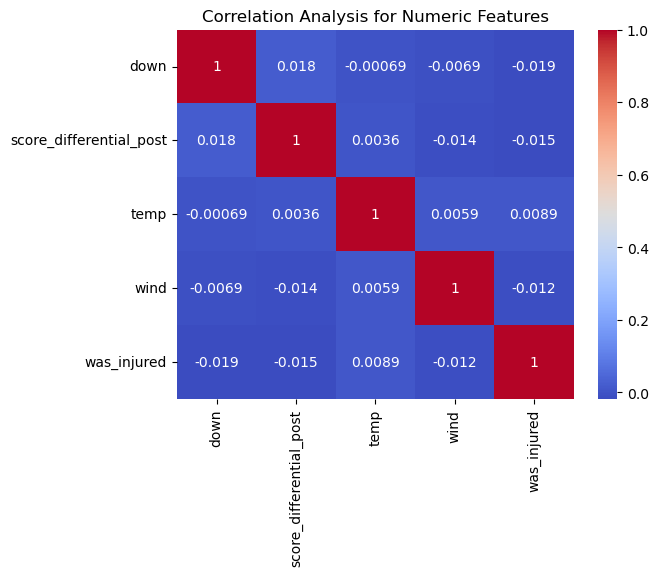

In [68]:
# correlation_analysis.py

import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features and target
numeric_features = ["down", "score_differential_post", "temp", "wind"]
data = play2024_df[numeric_features + ["was_injured"]]

# Calculate correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Analysis for Numeric Features")
plt.show()


In [69]:
# chi_square_test.py

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define categorical features
categorical_features = [
    "home_team", "away_team", "season_type", "play_type", "stadium", "roof", 
    "surface", "weather_condition", "temperature_category", "humidity_category", "wind_category"
]
data = play2024_df[categorical_features + ["was_injured"]]
X = data.drop(columns=["was_injured"])
y = data["was_injured"]

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='if_binary')
X_encoded = encoder.fit_transform(X)

# Perform chi-square test
chi2_scores, p_values = chi2(X_encoded, y)
chi2_results = pd.DataFrame({
    'feature': encoder.get_feature_names_out(X.columns),
    'chi2_score': chi2_scores,
    'p_value': p_values
}).sort_values(by='chi2_score', ascending=False)

print("Chi-Square Test Results:")
print(chi2_results)


Chi-Square Test Results:
                                feature    chi2_score   p_value
73                        play_type_run  1.736112e+01  0.000031
74                        play_type_nan  1.376931e+01  0.000207
65                play_type_extra_point  1.184514e+01  0.000578
66                 play_type_field_goal  1.108606e+01  0.000870
116                  surface_matrixturf  7.962315e+00  0.004776
..                                  ...           ...       ...
88             stadium_Highmark Stadium  8.272778e-03  0.927528
3                         home_team_BUF  8.272778e-03  0.927528
9                         home_team_DEN  4.381157e-03  0.947226
82   stadium_Empower Field at Mile High  4.381157e-03  0.947226
64                      season_type_REG  7.070403e-30  1.000000

[138 rows x 3 columns]


In [29]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define a broader set of columns to improve context
columns_needed = [
    "home_team", "away_team", "season_type",
    "down", "play_type", "score_differential_post", 
    "stadium", "roof", "surface", "temp", "wind", "was_injured", "missed_time",
    "weather_condition", "temperature_category", "humidity_category", "wind_category"
]

# Select relevant columns from the DataFrame
X = play2024_df[columns_needed].drop(columns=["was_injured", "missed_time"])
y = play2024_df['was_injured']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define numerical and categorical features
numeric_features = ["down", "score_differential_post", "temp", "wind"]
categorical_features = ["home_team", "away_team", "season_type", "play_type", "stadium", "roof", 
                        "surface", "weather_condition", "temperature_category", "humidity_category", "wind_category"]

# Preprocessing for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the Logistic Regression model with adjusted regularization
model = LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0, penalty='l2')

# Apply SMOTE with a lower sampling strategy to avoid overcompensation
smote = SMOTE(sampling_strategy=0.2, random_state=42)

# Create the pipeline with preprocessing, SMOTE, and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.98      0.59      0.74      5178
           1       0.02      0.47      0.04        91

    accuracy                           0.59      5269
   macro avg       0.50      0.53      0.39      5269
weighted avg       0.97      0.59      0.73      5269



In [42]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from imblearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Define columns to use
columns_needed = [
    "home_team", "away_team", "season_type",
    "down", "play_type", "score_differential_post", 
    "stadium", "roof", "surface", "temp", "wind", "was_injured", "missed_time",
    "weather_condition", "temperature_category", "humidity_category", "wind_category"
]

# Select relevant columns from the DataFrame
data = play2024_df[columns_needed]

# Separate majority and minority classes
injury_class = data[data['was_injured'] == 1]
no_injury_class = data[data['was_injured'] == 0]

# Bootstrapping the injury class to add more samples with replacement
bootstrap_injury = injury_class.sample(n=8000, replace=True, random_state=42)

# Combine bootstrapped minority samples with majority class
augmented_data = pd.concat([no_injury_class, injury_class, bootstrap_injury])

# Separate features and target
X = augmented_data.drop(columns=["was_injured", "missed_time"])
y = augmented_data['was_injured']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define numerical and categorical features
numeric_features = ["down", "score_differential_post", "temp", "wind"]
categorical_features = ["home_team", "away_team", "season_type", "play_type", "stadium", "roof", 
                        "surface", "weather_condition", "temperature_category", "humidity_category", "wind_category"]

# Preprocessing for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Balanced Random Forest model with SMOTE
model = BalancedRandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Hybrid sampling strategy with SMOTE after bootstrapping
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Create the pipeline with preprocessing, SMOTE, and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Adjust decision threshold
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
threshold = 0.5  # Adjust this threshold as needed (e.g., 0.35, 0.4, etc.)
y_pred = (y_pred_proba >= threshold).astype(int)  # Convert probabilities to binary predictions

# Evaluate performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.58
Precision: 0.34
Recall: 0.74
F1 Score: 0.47
              precision    recall  f1-score   support

           0       0.86      0.53      0.66      5178
           1       0.34      0.74      0.47      1691

    accuracy                           0.58      6869
   macro avg       0.60      0.64      0.56      6869
weighted avg       0.73      0.58      0.61      6869

